In [54]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

In [55]:
Y_START, Y_END = 25, 35
X_START, X_END = 0, 1315

In [56]:
def imread_gs(path: str) -> np.ndarray:
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def crop(img: np.ndarray,
         x_params: tuple[int, int] = (X_START, X_END),
         y_params: tuple[int, int] = (Y_START, Y_END)
        ) -> np.ndarray:
    return img[y_params[0]:y_params[1], x_params[0]:x_params[1]]


def show(img: np.ndarray) -> None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap='gray')

In [57]:
f0 = imread_gs('data/20240306/E1_2024-03-06-170901-0000.tif')

1. find max sum axis=1
2. cut off signal on laser side (flip if necessary)
3. find new max sum axis=1

In [58]:
f0_max1 = np.where(f0.sum(axis=1) == f0.sum(axis=1).max())[0][0]
WIDTH = 15

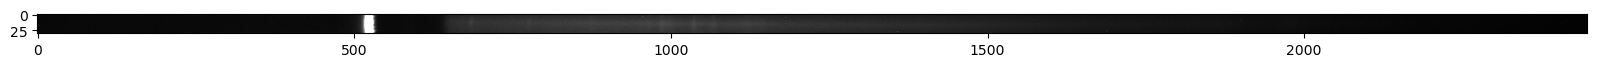

In [174]:
show(f0[ f0_max1-WIDTH:f0_max1+WIDTH, ::-1])

In [230]:
center_line = f0[f0_max1, :]
laser_loc = np.where(center_line == max(center_line))[0][0]
laser_left = laser_loc < len(center_line)/2

if laser_left:
    f0 = np.flip(f0, axis=1)
    center_line = f0[f0_max1, ::-1]
    laser_loc = np.where(center_line == max(center_line))[0][0]

center_gradient = np.gradient(gaussian_filter(center_line, 5))
laser_onset_loc = np.where(center_gradient[:laser_loc] == 0)[0][-1]

gradient_condition = center_gradient[:laser_onset_loc] > -1
brightness_condition = center_line[:laser_onset_loc] > 50
signal_loc = np.where(gradient_condition & brightness_condition)[0][-1]

In [232]:
f0 = f0[:, :signal_loc]
f0_max = np.where(f0.sum(axis=1) == f0.sum(axis=1).max())[0][0]
f0_max

640

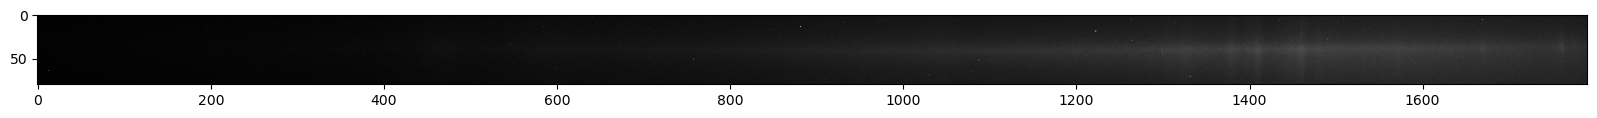

In [233]:
show(f0[600:680, :])

In [234]:
f0_c = np.flip(f0[f0_max-WIDTH:f0_max+WIDTH, :], axis=1)  # cropped

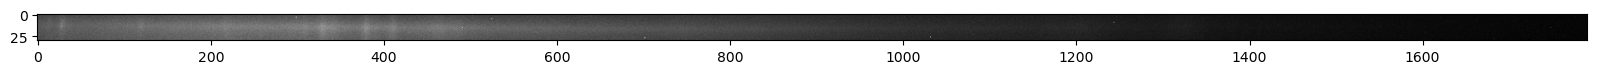

In [235]:
show(f0_c)

In [236]:
f0_s = f0_c.sum(axis=0, dtype=np.int64)  # spectrum

# minima, maxima

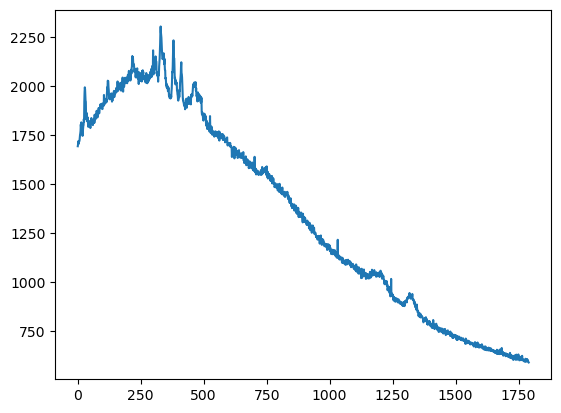

In [237]:
plt.plot(f0_s)

[  14   29  120  218  258  309  330  380  411  464  745 1176 1317]


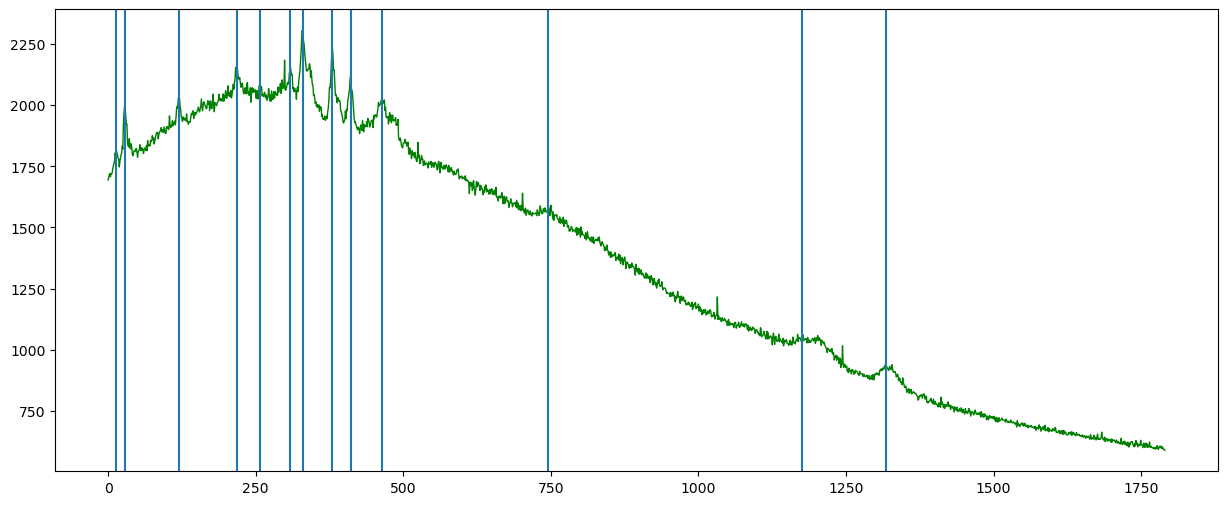

In [238]:
f0_smoothed = gaussian_filter(f0_s, 2)
f0_peaks = find_peaks(f0_smoothed, prominence=15)[0]
print(f0_peaks)

plt.figure(figsize=(15, 6))
# plt.plot(f0_smoothed, 'r--', lw=1)
plt.plot(f0_s, 'g', lw=1)
for x in f0_peaks:
    plt.axvline(x)

[  19   43   50  136  252  268  318  366  399  425  718 1153 1292]


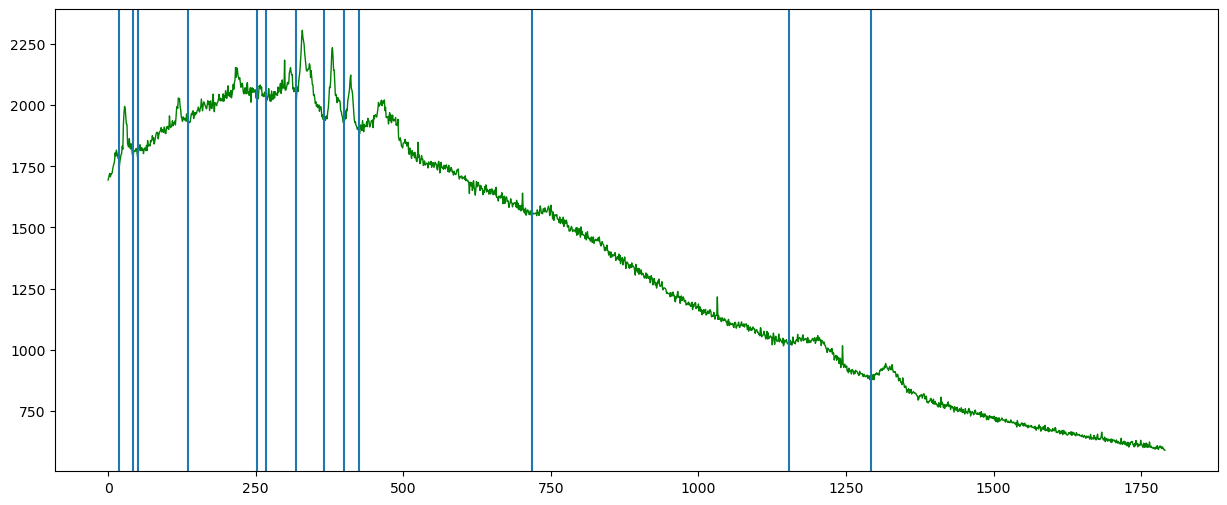

In [239]:
f0_smoothed = gaussian_filter(f0_s, 2)
f0_minima = find_peaks(-f0_smoothed, prominence=15)[0]
print(f0_minima)

plt.figure(figsize=(15, 6))
# plt.plot(f0_smoothed, 'r--', lw=1)
plt.plot(f0_s, 'g', lw=1)
for x in f0_minima:
    plt.axvline(x)

In [240]:
def gnorm(spec):
    return (spec - np.mean(spec))/np.std(spec)

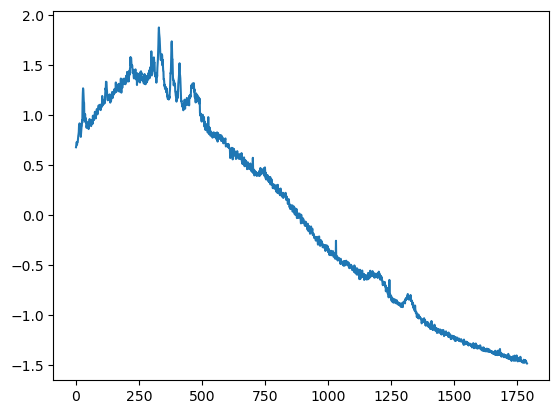

In [241]:
plt.plot(gnorm(f0_s))

# reference spectrum of corundum

In [242]:
def readline(line: str) -> tuple[float, float]:
    x, y = line.split('\t')
    return (float(x), float(y))

In [243]:
with open('data/sapphire_ref_cm++.txt') as f:
    sap_ref = [ readline(l) for l in f.readlines()[1:] ]

In [244]:
wvns, vals = np.array(sap_ref).transpose()
wvls = 2*np.pi/wvns

In [245]:
wvns = wvns[10:]
vals = vals[10:]
wvls = wvls[10:]

[379.02891, 416.36703, 644.43098, 1994.56975]


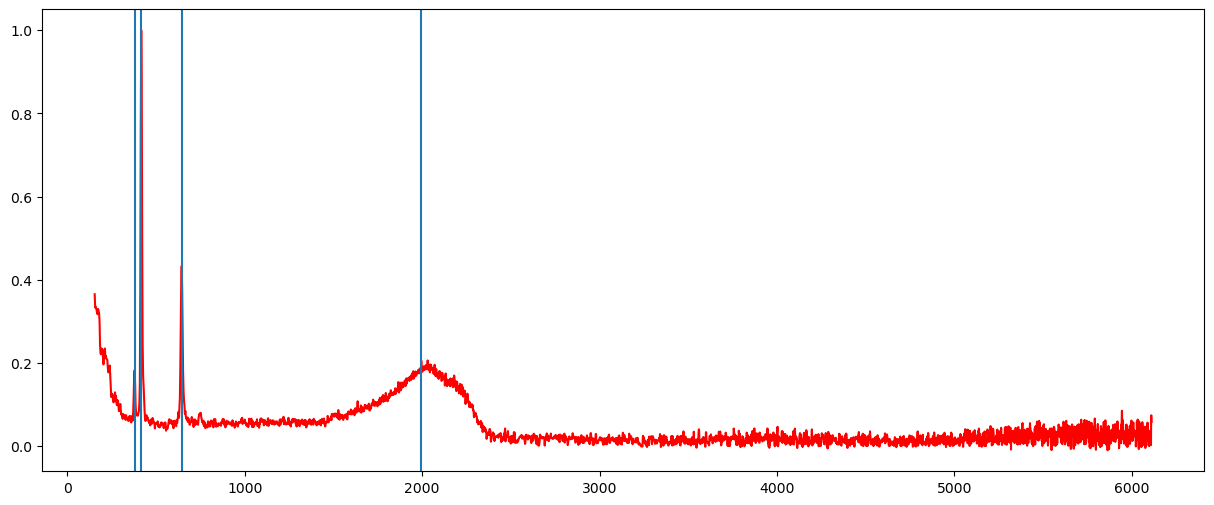

In [246]:
plt.figure(figsize=(15, 6))
plt.plot(wvns, vals, 'r')

ref_peak_n = find_peaks(vals, prominence=.1)[0]
ref_peaks = [ wvns[p] for p in ref_peak_n ]
print(ref_peaks)
for p in ref_peaks:
    plt.axvline(p)

# calibration

In [247]:
f0_fit = np.poly1d(np.polyfit(f0_peaks[:3], ref_peaks[:3], 2))
f0_wvn = f0_fit(np.arange(0, len(f0_s)))

In [248]:
f0_fit(f0_peaks[0])

379.0289099999997

[379.0289099999997, 416.36702999999983, 644.4309799999996]


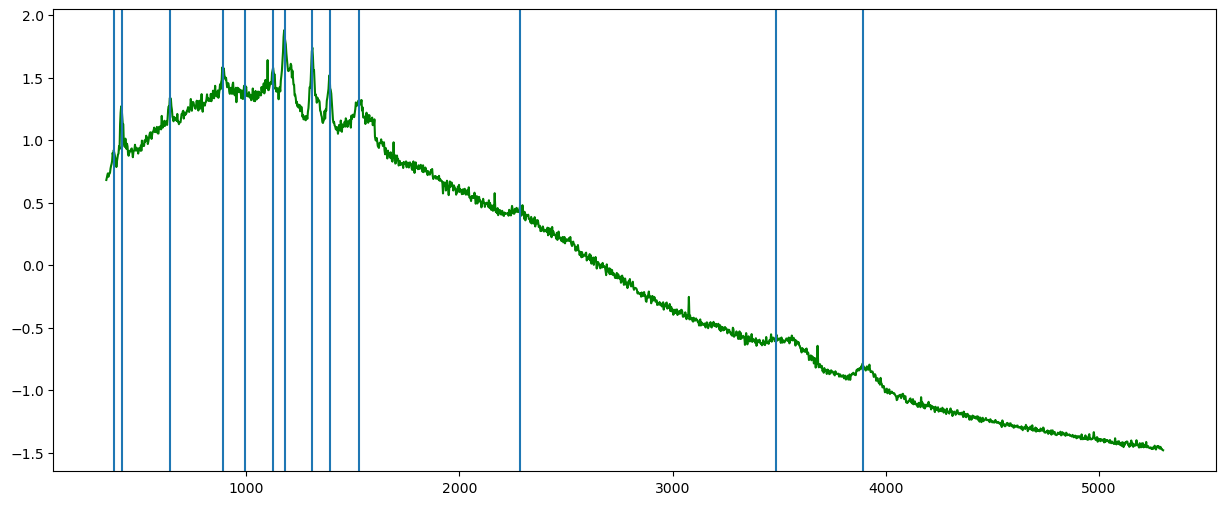

In [249]:
plt.figure(figsize=(15, 6))
plt.plot(f0_wvn, gnorm(f0_s), 'g')
for x in f0_peaks:
    plt.axvline(f0_wvn[x])

print([f0_wvn[x] for x in f0_peaks[:3]])

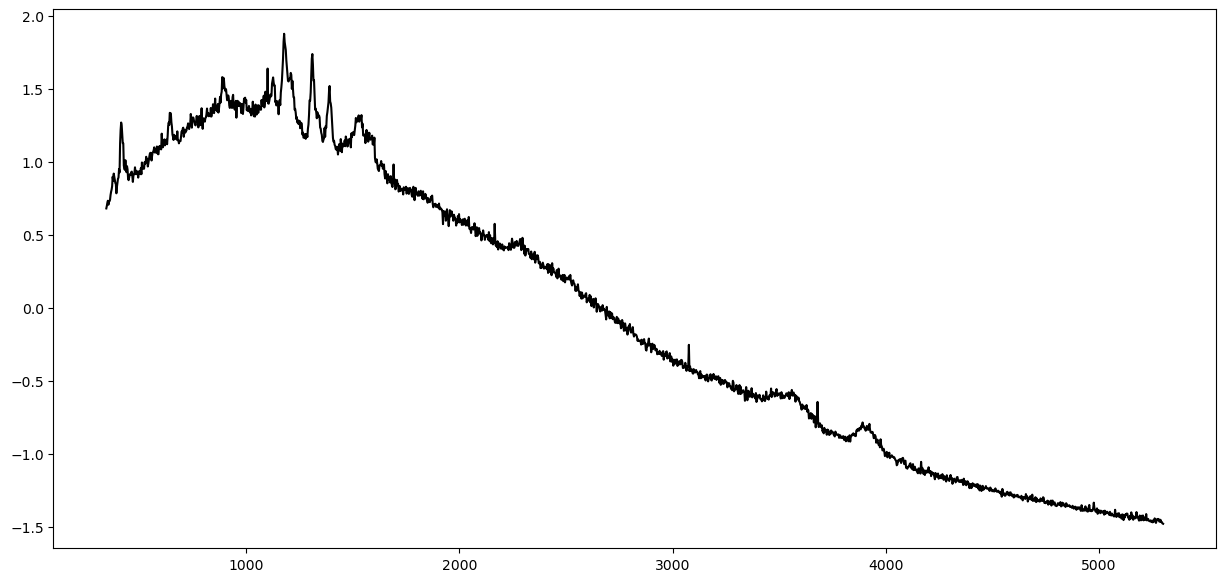

In [250]:
plt.figure(figsize=(15, 7))
plt.plot(f0_wvn, gnorm(f0_s), c='black')

# fitanje minimuma (weighted)

In [251]:
m1 = (f0_wvn > 1800) & (f0_wvn < 2000)
g1 = 20
m2 = f0_wvn > 4200
g2 = 20
m3 = (f0_wvn > 2900) & (f0_wvn < 3100)
g3 = 20

f0_min_wvn = [ *[ f0_wvn[x] for x in f0_minima ], *f0_wvn[m1][::g1], *f0_wvn[m2][::g2], *f0_wvn[m3][::g3] ]
f0_min_h = [ *[ gnorm(f0_s)[x] for x in f0_minima ], *gnorm(f0_s)[m1][::g1], *gnorm(f0_s)[m2][::g2], *gnorm(f0_s)[m3][::g3] ]
weights = [4]*len(f0_minima) + [1]*(len(f0_min_wvn) - len(f0_minima))

f0_fit_1w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 4, w=weights))
f0_fit_2w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 8, w=weights))
t = time()
f0_fit_3w = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 12, w=weights))
print(time() - t)

f0_fit_w = [ f0_fit_1w, f0_fit_2w, f0_fit_3w ]

0.00043773651123046875


In [252]:
wl = [ f'weighted x^{x}' for x in (3, 7, 11) ]
ul = [ f'unweighted x^{x}' for x in (3, 7, 11) ]
cl = [ 'gray', 'green', 'red' ]

(344.2450700435409, 5301.13118196319)

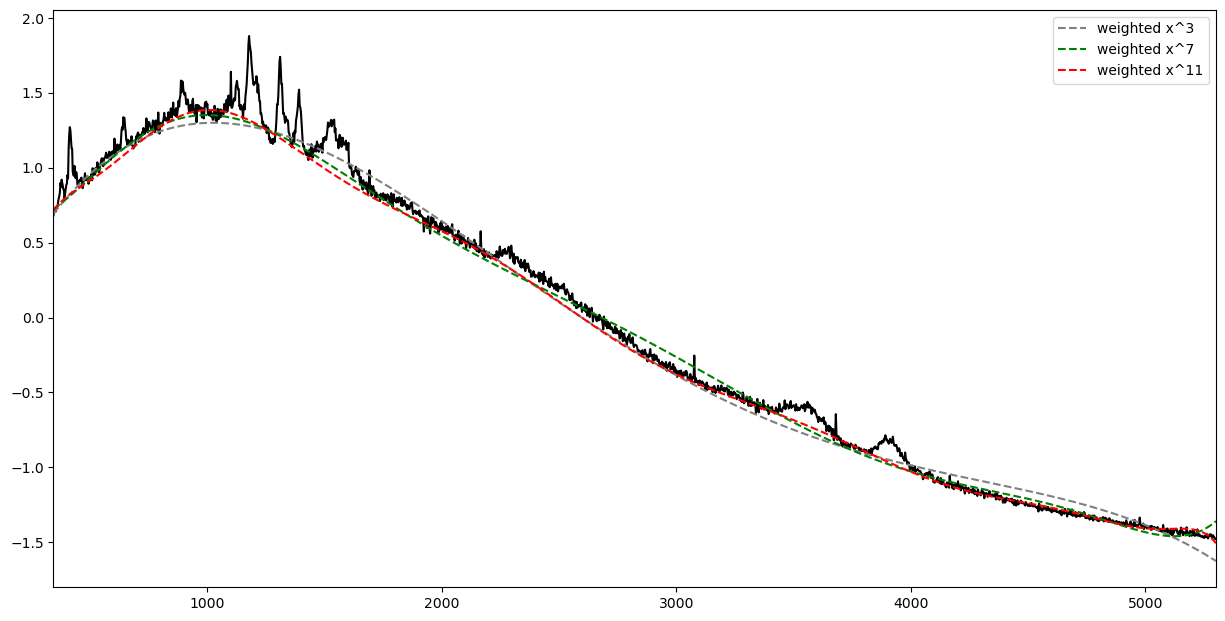

In [253]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
for i in range(3):
    plt.plot(f0_wvn, f0_fit_w[i](f0_wvn), c=cl[i],  ls='--', label=wl[i])
plt.legend()
plt.xlim(min(f0_wvn), max(f0_wvn))

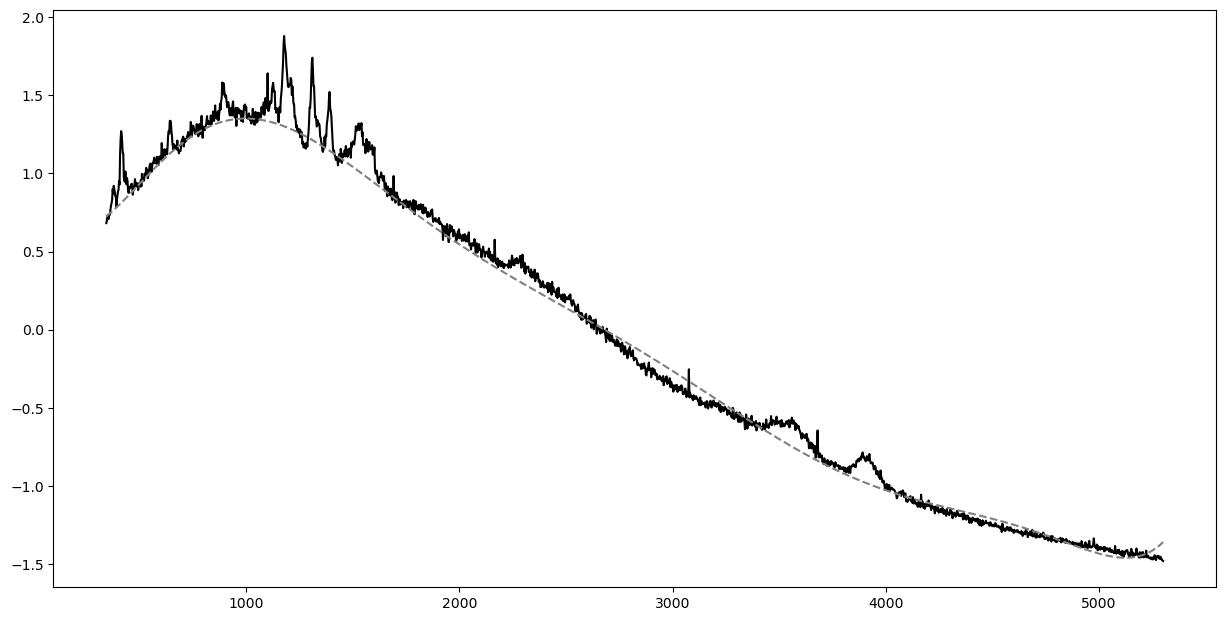

In [254]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_w[1](f0_wvn), c='gray', ls='--')

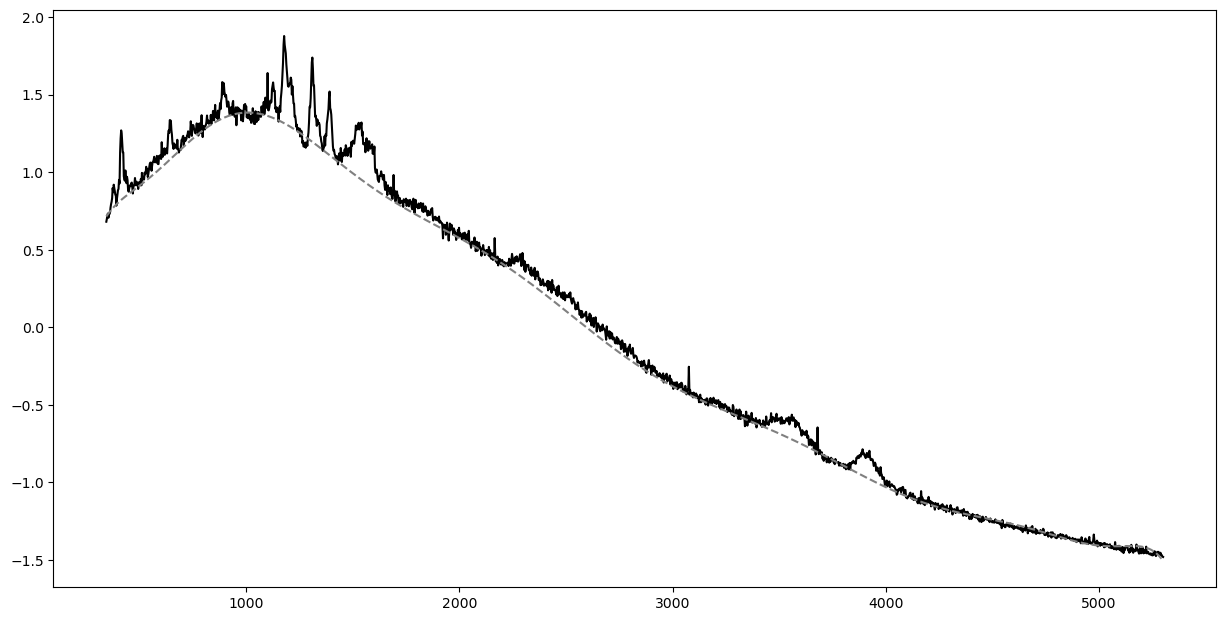

In [255]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_w[2](f0_wvn), c='gray', ls='--')

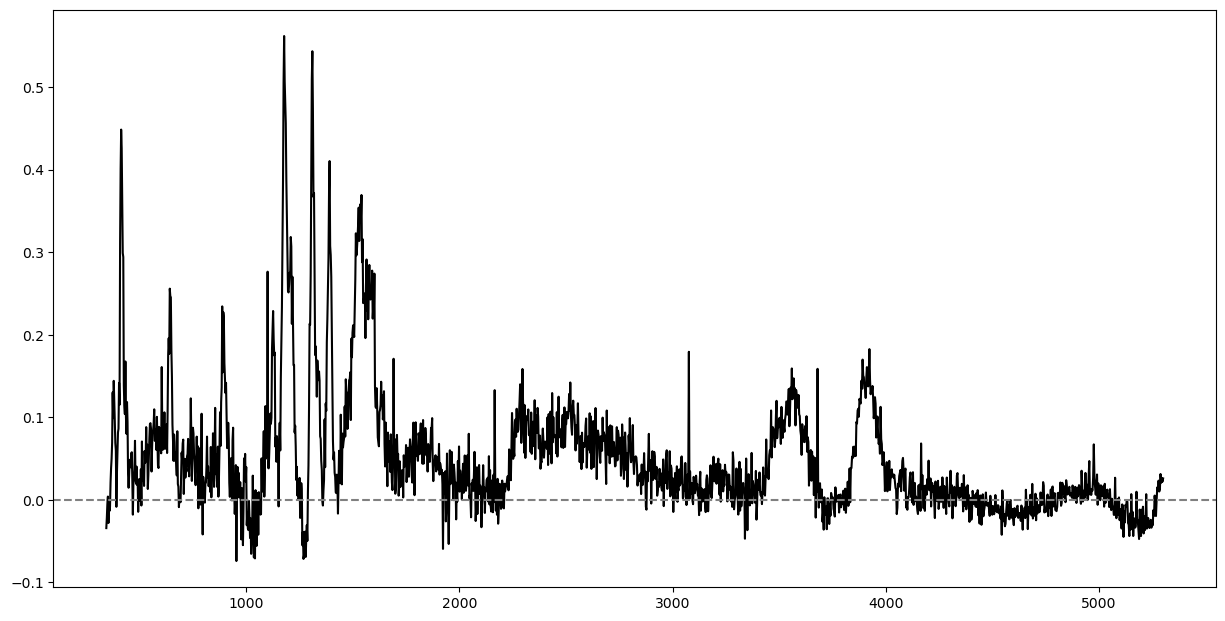

In [256]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s) - f0_fit_w[2](f0_wvn), c='black')
plt.axhline(c='gray', ls='--')

# fitanje minimuma (unweighted)

In [257]:
from time import time

In [258]:
f0_fit_1u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 4))
f0_fit_2u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 8))
t = time()
f0_fit_3u = np.poly1d(np.polyfit(f0_min_wvn, f0_min_h, 12))
print(time() - t)

f0_fit_u = [ f0_fit_1u, f0_fit_2u, f0_fit_3u ]

0.0004756450653076172


(344.2450700435409, 5301.13118196319)

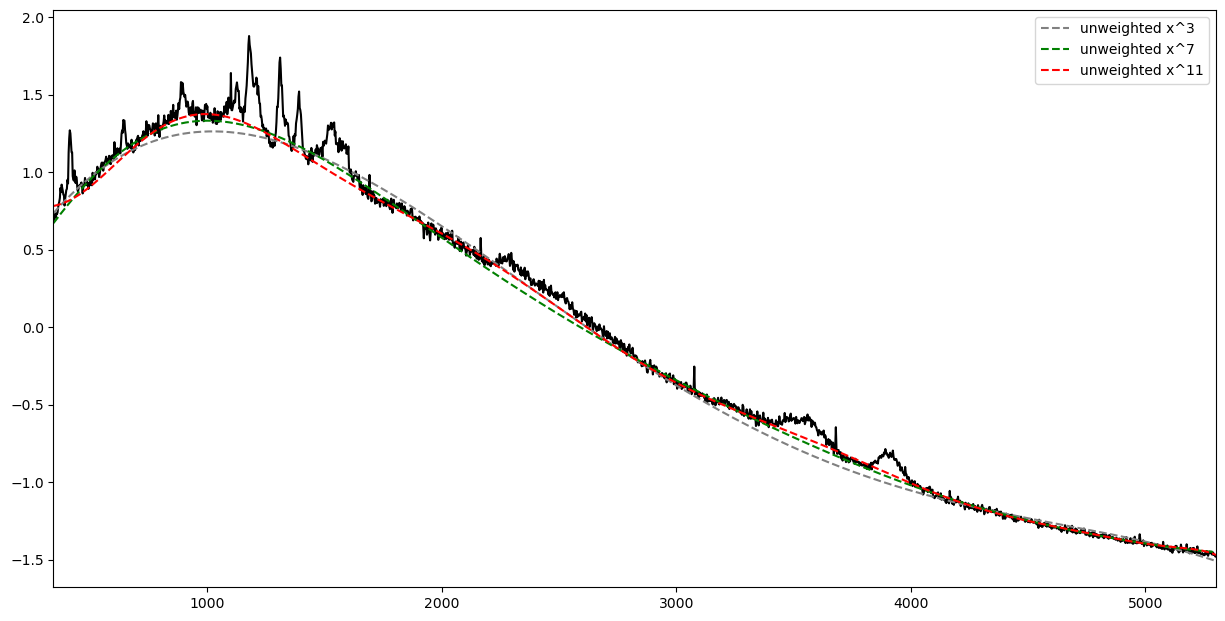

In [259]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
for i in range(3):
    plt.plot(f0_wvn, f0_fit_u[i](f0_wvn), c=cl[i],  ls='--', label=ul[i])
plt.legend()
plt.xlim(min(f0_wvn), max(f0_wvn))

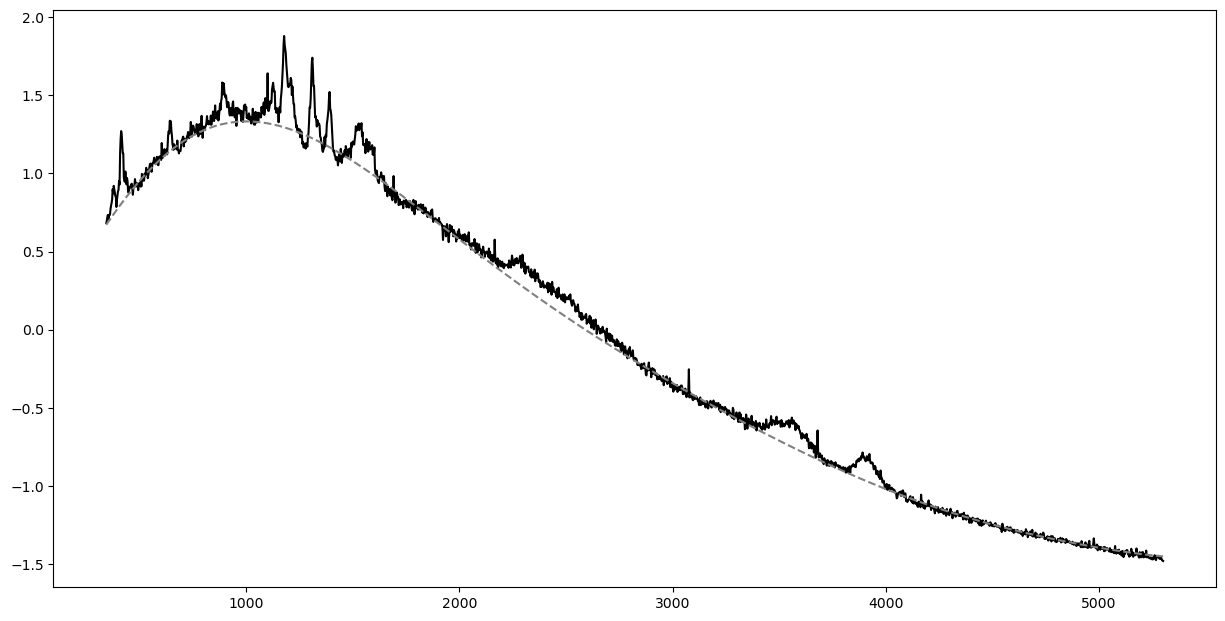

In [260]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_2u(f0_wvn), c='gray', ls='--')

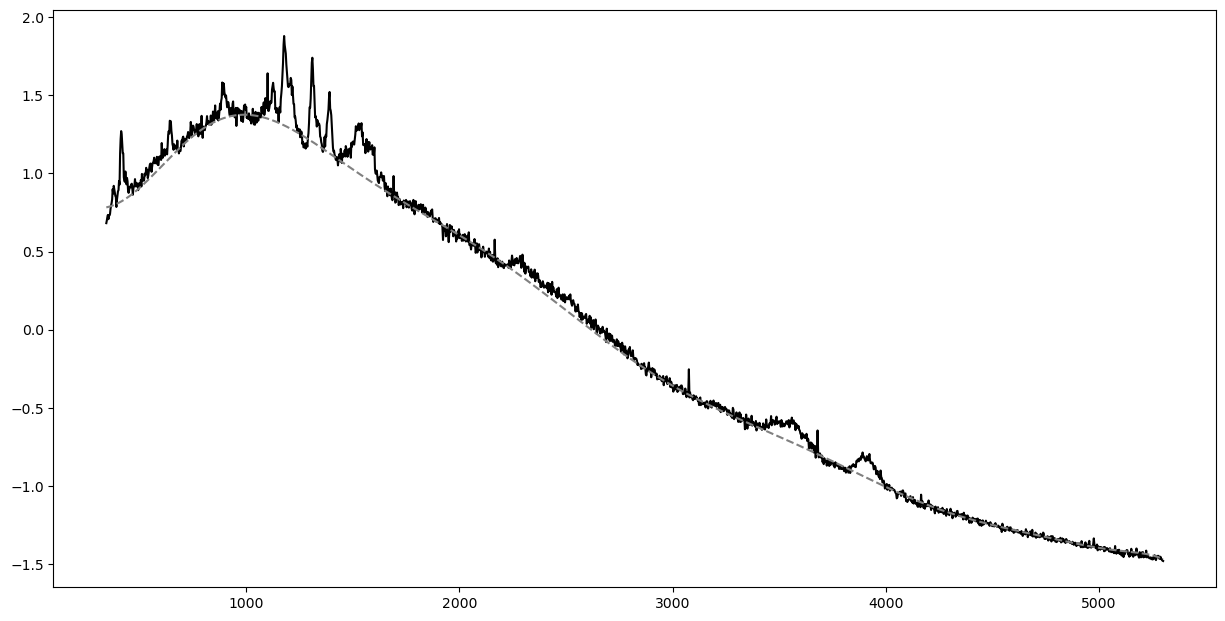

In [261]:
plt.figure(figsize=(15, 7.5))
plt.plot(f0_wvn, gnorm(f0_s), c='black')
plt.plot(f0_wvn, f0_fit_3u(f0_wvn), c='gray', ls='--')

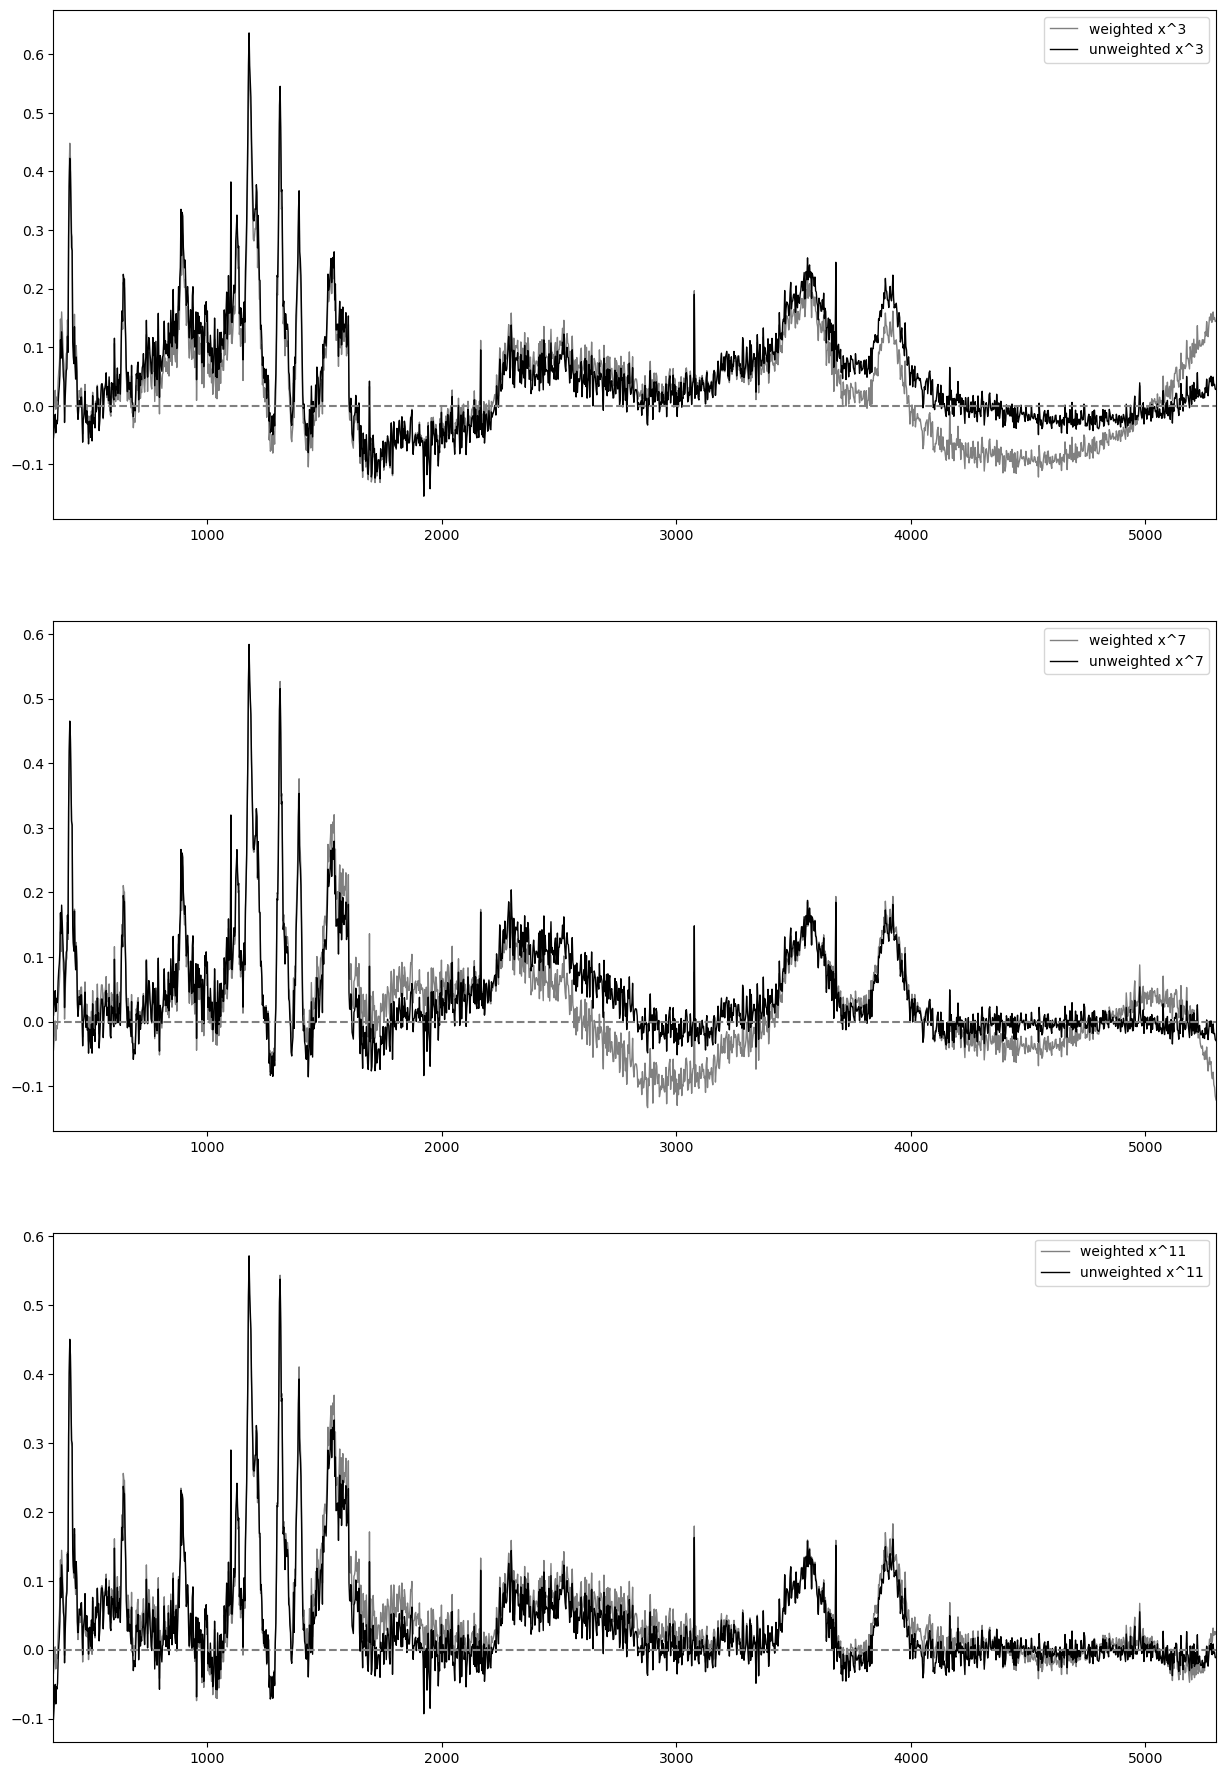

In [262]:
fig, ax = plt.subplots(3, figsize=(15, 22.5))

for i in range(3):
    ax[i].plot(f0_wvn, gnorm(f0_s) - f0_fit_w[i](f0_wvn), c='gray',  lw=1, label=wl[i])
    ax[i].plot(f0_wvn, gnorm(f0_s) - f0_fit_u[i](f0_wvn), c='black', lw=1, label=ul[i])
    ax[i].axhline(c='gray', ls='--')
    ax[i].legend()
    ax[i].set_xlim(min(f0_wvn), max(f0_wvn))